# BitTrack Project
## Send request and Get data

In [2]:
import requests
import csv
import json

import datetime
import time
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np

# Time in UNIX format
month = 2629743
now = int(time.time())
start_time = now - 3*month
DATALENGTH = 200
ema_length = 50

url = f"http://api.coincap.io/v2/assets/bitcoin/history?interval=h1"
print(url)

# Request data from the API
response = requests.request("GET", url, headers={}, data={})
json_data = json.loads(response.text.encode('utf8'))
# print(json_data)
bitcoin_data = json_data["data"]

df = pd.DataFrame(bitcoin_data)
## Export data as a csv file
# df.to_csv('BTCUSD.csv', index=False)
print(df.sample)
# df.dtypes

# Filter only the columns we need
df = pd.DataFrame(bitcoin_data, columns=['time', 'priceUsd'])
# Get last 200 rows and REVERSE, newest price on top (index 0)
df = df[:-DATALENGTH-1:-1]
print(df.sample)

# Convert 'priceUsd' datatype to something numeric
df['priceUsd'] = pd.to_numeric(df['priceUsd'], errors='coerce', downcast='integer').fillna(0, downcast='infer')
df.dtypes
df.info()

http://api.coincap.io/v2/assets/bitcoin/history?interval=h1
<bound method NDFrame.sample of                    priceUsd           time          circulatingSupply  \
0    34800.3310219969321962  1623250800000  18730937.0000000000000000   
1    36379.7115341843627672  1623254400000  18730962.0000000000000000   
2    36542.0639571123462899  1623258000000  18730962.0000000000000000   
3    36556.9094483591884766  1623261600000  18731025.0000000000000000   
4    35990.1261198657888333  1623265200000  18731025.0000000000000000   
..                      ...            ...                        ...   
715  32921.8338575364617590  1625824800000  18743737.0000000000000000   
716  32873.1741207033871805  1625828400000  18743737.0000000000000000   
717  32762.9313281515375710  1625832000000  18743737.0000000000000000   
718  32956.4343844384495689  1625835600000  18743737.0000000000000000   
719  33404.8156901919044090  1625839200000  18743737.0000000000000000   

                         date  

In [3]:
# Check data 
prices = df['priceUsd']
print(prices)

719    33404.815690
718    32956.434384
717    32762.931328
716    32873.174121
715    32921.833858
           ...     
524    33250.606576
523    33294.671271
522    33482.768068
521    33448.664561
520    33680.401524
Name: priceUsd, Length: 200, dtype: float64


In [4]:
# Calculate and check last ema value 
count = 0
def ema(prices, count, length = ema_length, smoothing = 2):
    multiplier = smoothing/(1+length)
    if count < length:
        # print(prices.iloc[count])
        price = (prices.iloc[count] * multiplier) 
        count += 1
        return price + ema(prices, count ) * (1 - multiplier)
    return prices.iloc[count]

In [5]:
print("EMA50 H1:", ema(df['priceUsd'], count))

EMA50 H1: 33279.42162237206


In [6]:
# Process UNIX time to readable form
timeStamp =  df['time'].values.tolist()
timeStamp = [x / 1000 for x in timeStamp]

In [7]:
# Insert readable timeStamp column to 'df'
df['timeStamp'] = pd.to_datetime(timeStamp, unit='s')

In [8]:
# Check
df.sample

<bound method NDFrame.sample of               time      priceUsd           timeStamp
719  1625839200000  33404.815690 2021-07-09 14:00:00
718  1625835600000  32956.434384 2021-07-09 13:00:00
717  1625832000000  32762.931328 2021-07-09 12:00:00
716  1625828400000  32873.174121 2021-07-09 11:00:00
715  1625824800000  32921.833858 2021-07-09 10:00:00
..             ...           ...                 ...
524  1625137200000  33250.606576 2021-07-01 11:00:00
523  1625133600000  33294.671271 2021-07-01 10:00:00
522  1625130000000  33482.768068 2021-07-01 09:00:00
521  1625126400000  33448.664561 2021-07-01 08:00:00
520  1625122800000  33680.401524 2021-07-01 07:00:00

[200 rows x 3 columns]>

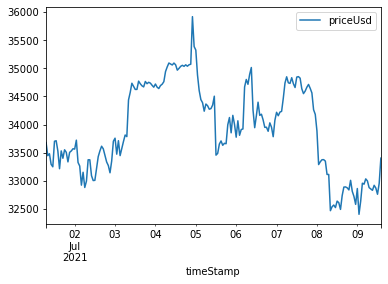

In [9]:
# Plot the data
df.plot(x ='timeStamp', y='priceUsd', kind = 'line')
plot.show()

## Calculate the possible EMA for each timeStamp
'possible' means timeStamp that have at lease 50 values before it. After that, we add EMA value along with the above figure.

In [10]:
short_df = df.head(DATALENGTH-ema_length)
short_df.reset_index()

,index,time,priceUsd,timeStamp
0,719,1625839200000,33404.815690,2021-07-09 14:00:00
1,718,1625835600000,32956.434384,2021-07-09 13:00:00
2,717,1625832000000,32762.931328,2021-07-09 12:00:00
3,716,1625828400000,32873.174121,2021-07-09 11:00:00
4,715,1625824800000,32921.833858,2021-07-09 10:00:00
...,...,...,...,...
145,574,1625317200000,34625.397493,2021-07-03 13:00:00
146,573,1625313600000,34625.047582,2021-07-03 12:00:00
147,572,1625310000000,34679.156439,2021-07-03 11:00:00
148,571,1625306400000,34735.007056,2021-07-03 10:00:00


In [11]:
short_df['EMA'] = np.zeros(( DATALENGTH-ema_length, 1))

<ipython-input-11-b2c0fb1e9939>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['EMA'] = np.zeros(( DATALENGTH-ema_length, 1))


In [12]:
# short_df['N'] = np.arange(len(short_df))
short_df.insert(loc=0, column='N', value=np.arange(len(short_df)))

In [13]:
# Try modifying a value in EMA column
short_df.loc[713,'EMA'] = 999999
# Try accessing short_df
print(short_df['EMA'].iloc[-1])

0.0
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [14]:
# Finalize 'ema' function to run in for loop
def ema(prices, count, length = ema_length, smoothing = 2):
    multiplier = smoothing/(1+length)
    if count < length:
        # print(prices.iloc[count])
        price = (prices.iloc[count] * multiplier) 
        count += 1
        return price + ema(prices, count ) * (1 - multiplier)
    return prices.iloc[count]

# Calculate ema values and replace them into the dataframe
for i in range(0, DATALENGTH-ema_length):
    count = 0
    # short_df.iloc[ ?,4 ] => 'EMA' column
    short_df.iloc[ i,4 ] = ema( df['priceUsd'].iloc[ i: ], count )


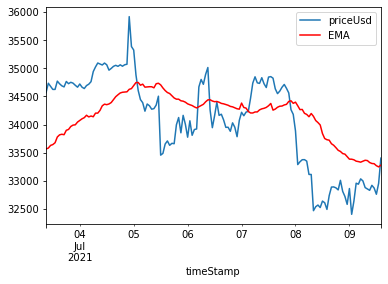

In [15]:
# Reference article https://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot
ax = plot.gca()
short_df.plot(kind='line',x='timeStamp',y='priceUsd', ax=ax)
short_df.plot(kind='line',x='timeStamp',y='EMA', color='red', ax=ax)
plot.show()

## Create a while loop to update price constantly

## Alarm when PRICE cross EMA

## Analyze profit/loss if trade base on EMA 
using data in the past 1 year
with R:R=1:1, TP = SL = 5%. TP 80% when reach target, move SL to entry.
